In [2]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(stars, warn.conflicts = FALSE)
library(sf, warn.conflicts = FALSE)
library(readr, warn.conflicts = FALSE)

source("src/load/load.R")
source("src/pairing/utils.R")


tvar <- "T_MIN"
flavor <- "qc_era5"

missing_climats <- tibble(identifier = as.integer(read_lines("temp/pairing/missing_scia_clim_2020.txt")))
dem <- read_stars("temp/dem/dem30.tif")
m.scia <- load.metadata("SCIA", tvar, .suffix = "_dated") |>
    semi_join(missing_climats, by = "identifier") |>
    prepare_metadata(dem) |>
    select(!c(net_code, user_code, province, valid_days, ends_with("year")))
m.dpc <- load.metadata("DPC", tvar, flavor) |>
    prepare_metadata(dem) |>
    select(!c(region_, province, internal_id))
rm(dem)
gc()


Caricamento del pacchetto richiesto: abind

Caricamento del pacchetto richiesto: sf

Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE

terra 1.7.55

Cache found: SCIA/T_MIN, suffix: <_dated>, loading from disk

Cache found: DPC/T_MIN/qc_era5, suffix: <>, loading from disk



,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,1987932,106.2,3763895,201.1,NA,2836170,151.5
Vcells,3036343,23.2,14011088,106.9,16384,13879787,105.9


Associo stazioni entro 5 km di distanza, una dimensione tipica per un paese (?).

In [6]:
m.scia |> filter(str_detect(anagrafica, "AGOGNA"))


,identifier,elevation,state,anagrafica,rete,first_date,last_date,geometry,dem
,<int>,<dbl>,<fct>,<chr>,<fct>,<date>,<date>,<POINT [arc_degree]>,<dbl>
1,7541,208,Piemonte,MOMO AGOGNA,Idrografica,2005-05-13,2010-12-31,POINT (8.547717 45.57114),208.0297
2,7503,143,Piemonte,NOVARA AGOGNA,Idrografica,2003-01-01,2010-12-31,POINT (8.590679 45.43102),141.4600


In [3]:
sdist <- units::set_units(5, "km")
m.matches <- st_join(m.scia, m.dpc, join = st_is_within_distance, dist = sdist, left = FALSE) |> # Attenzione! Non tutte le righe hanno un match
    add_distances(m.scia, m.dpc)


Some stations won't have a match:

In [3]:
nrow(missing_climats) - m.matches |>
    group_by(identifier.x) |>
    n_groups()


[1] 581

In [4]:
m.matches |> slice_head(n = 10)


Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson



identifier.x,elevation.x,state.x,anagrafica.x,rete,first_date,last_date,geometry,dem.x,anagrafica.y,version,identifier.y,elevation.y,state.y,dem.y,distance
<int>,<dbl>,<fct>,<chr>,<fct>,<date>,<date>,<POINT [arc_degree]>,<dbl>,<chr>,<int>,<chr>,<dbl>,<fct>,<dbl>,<dbl>
14716,317,Sardegna,ABBASANTA,RETE SARDEGNA 2022,1988-05-12,2011-12-31,POINT (8.818833 40.12547),317.01907,ABBASANTA,2,TN_SAR_OR_ABBASANTA_02_000420100.era,320,Sardegna,320.7057,680.20503
7332,1645,Piemonte,ACCEGLIO,Idrografica,1989-06-15,2010-12-31,POINT (6.981433 44.48515),1698.61694,ACCEGLIO,2,TN_PIE_CN_ACCEGLIO_02_000108500.era,1610,Piemonte,1698.6169,23.44744
7650,2000,Piemonte,ACCEGLIO COLLET,Idrografica,2004-08-27,2010-12-31,POINT (6.906438 44.52014),2024.89136,ACCEGLIO_COLLET,2,TN_PIE_CN_ACCEGLIO_COLLET_02_000406200.era,2010,Piemonte,2024.8914,137.00671
7650,2000,Piemonte,ACCEGLIO COLLET,Idrografica,2004-08-27,2010-12-31,POINT (6.906438 44.52014),2024.89136,LA_COLLETTA,2,TN_PIE_CN_LA_COLLETTA_02_000561100.era,2612,Piemonte,2737.8113,4250.55556
14098,194,Sicilia,ACIREALE,RETE SICILIA OSS. ACQUE TEMP,1929-01-01,2021-12-31,POINT (15.16589 37.62158),196.01265,ACIREALE,1,TN_SIC_CT_ACIREALE_01_000469700.era,182,Sicilia,196.0126,15.18874
14098,194,Sicilia,ACIREALE,RETE SICILIA OSS. ACQUE TEMP,1929-01-01,2021-12-31,POINT (15.16589 37.62158),196.01265,ACI_SAN_FILIPPO,1,TN_SIC_CT_ACI_SAN_FILIPPO_01_000791000.era,221,Sicilia,221.0547,4764.68341
14098,194,Sicilia,ACIREALE,RETE SICILIA OSS. ACQUE TEMP,1929-01-01,2021-12-31,POINT (15.16589 37.62158),196.01265,LAVINAIO,1,TN_SIC_CT_LAVINAIO_01_000795500.era,399,Sicilia,408.1364,4728.12670
7300,198,Piemonte,ACQUI TERME,Idrografica,1988-01-27,2010-12-31,POINT (8.479704 44.67866),206.24304,ACQUI_TERME,2,TN_PIE_AL_ACQUI_TERME_02_000084600.era,159,Piemonte,164.1505,1295.17184
14758,490,Sardegna,AGLIENTU,RETE SARDEGNA 2022,1988-06-07,2005-12-31,POINT (9.112771 41.07814),423.51721,AGLIENTU,2,TN_SAR_SS_AGLIENTU_02_000420200.era,430,Sardegna,423.5172,578.50420


In [32]:
# analysis <- m.matches |> analyze_match("SCIA", "DPC", tvar, ...s = list(flavor)) |> relocate(starts_with("anagrafica"), version, distance, delH, delZ, strSym, delT, sdT, corT, overlap, minilap
# write_sf(analysis, "temp/pairing/T_MIN_scia_dpc_2km.geojson"))
analysis <- read_sf("temp/pairing/T_MIN_scia_dpc_2km.geojson")


In [18]:
analysis |>
    select(starts_with("identifier"), distance, delT, anagrafica.x, overlap, minilap, valid_days_both) |>
    slice_head(n = 5)


identifier.x,identifier.y,distance,delT,anagrafica.x,overlap,minilap,valid_days_both,geometry
<int>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<POINT [arc_degree]>
14716,TN_SAR_OR_ABBASANTA_02_000420100.era,680.20503,1.0317564,ABBASANTA,0.1683559,0.30039203,1839,POINT (8.818833 40.12547)
7332,TN_PIE_CN_ACCEGLIO_02_000108500.era,23.44744,0.2195535,ACCEGLIO,0.3602906,0.28924516,1299,POINT (6.981433 44.48515)
7650,TN_PIE_CN_ACCEGLIO_COLLET_02_000406200.era,137.00671,0.4168067,ACCEGLIO COLLET,0.1852595,0.56014644,1071,POINT (6.906438 44.52014)
7650,TN_PIE_CN_LA_COLLETTA_02_000561100.era,4250.55556,4.0723214,ACCEGLIO COLLET,0.1874104,0.05857741,112,POINT (6.906438 44.52014)
14098,TN_SIC_CT_ACIREALE_01_000469700.era,15.18874,1.3055556,ACIREALE,0.1429875,1.00000000,18,POINT (15.16589 37.62158)


In [49]:
naive_score <- function(data) {
    data |> mutate(
        score_dist = (1 - pmin(pmax(strSym, 0.5), 0.9)) * (1 - pmin(pmax(minilap, 0.1), 0.9)) * log10(distance) * (abs(delT) + log(abs(delH))) / valid_days_both
    )
}


In [16]:
analysis |>
    drop_na(delT) |>
    group_by(identifier.x) |>
    slice_min(delT, n = 3) |>
    select(starts_with("anagrafica"), version, distance, delT, strSym, overlap, minilap, valid_days_both)


anagrafica.x,anagrafica.y,version,distance,delT,strSym,overlap,minilap,valid_days_both,geometry
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<POINT [arc_degree]>
C.A.M.S.E.,CAMSE,2,32.60142,0.3424669,1.0000000,0.82909328,0.96414100,4759,POINT (12.07796 44.6022)
C.A.M.S.E.,CAMSE,2,32.60142,0.3424669,1.0000000,0.82909328,0.96414100,4759,POINT (12.07796 44.6022)
Finale Emilia,FINALE_EMILIA,2,92.52703,0.3933232,1.0000000,0.80999398,0.89398039,5287,POINT (11.28486 44.84083)
Finale Emilia,FINALE_EMILIA,2,92.52703,0.3933232,1.0000000,0.80999398,0.89398039,5287,POINT (11.28486 44.84083)
Martorano,MARTORANO,2,264.10820,0.3805501,1.0000000,0.81148429,0.90459364,6144,POINT (12.27018 44.16858)
Martorano,MARTORANO,2,264.10820,0.3805501,1.0000000,0.81148429,0.90459364,6144,POINT (12.27018 44.16858)
Martorano,CESENA_ARPA,1,4011.96667,1.5095337,0.4898148,0.68544601,0.85954421,5318,POINT (12.27018 44.16858)
Martorano,CESENA_ARPA,1,4011.96667,1.5095337,0.4898148,0.68544601,0.85954421,5318,POINT (12.27018 44.16858)
Loiano,LOIANO_ARPA,2,1526.29836,0.3356924,0.8666667,0.76937891,0.90687135,6203,POINT (11.33013 44.24691)


In [51]:
joined.1 <- st_join(m.scia, m.dpc, left = FALSE)


,identifier.x,elevation.x,state.x,anagrafica.x,rete,geometry,dem.x,anagrafica.y,version,identifier.y,elevation.y,state.y,dem.y
,<int>,<dbl>,<fct>,<chr>,<fct>,<POINT [arc_degree]>,<dbl>,<chr>,<int>,<chr>,<dbl>,<fct>,<dbl>
1,8136,1017,Veneto,Asiago - aeroporto,Idrografica,POINT (11.51124 45.88276),1011.86084,ASIAGO_AEROPORTO_CMT,1,TN_VEN_VI_ASIAGO_AEROPORTO_CMT_01_200251189.era,0,Veneto,1011.86084
2,5833,70,Liguria,Calice Ligure,Regionale ARPA Liguria,POINT (8.30205 44.19573),113.16167,CALICE_LIGURE_CA_ROSSE,2,TN_LIG_SV_CALICE_LIGURE_CA_ROSSE_02_200043088.era,50,Liguria,113.16167
3,7202,175,Liguria,Casale di Pignone,Regionale ARPA Liguria,POINT (9.71496 44.18992),253.99197,CASALE_DI_PIGNONE,2,TN_LIG_SP_CASALE_DI_PIGNONE_02_200043202.era,175,Liguria,253.99197
4,10690,535,Marche,Cesane Foresta,Idrografica,POINT (12.7675 43.6926),557.98645,CESANE_FORESTA,2,TN_MAR_PU_CESANE_FORESTA_02_200043330.era,-1,Marche,557.98645
5,6650,615,Liguria,Cichero,Regionale ARPA Liguria,POINT (9.32194 44.42107),627.97565,CICHERO,2,TN_LIG_GE_CICHERO_02_200043100.era,615,Liguria,627.97565
6,5858,16,Liguria,Diano Castello,Regionale ARPA Liguria,POINT (8.06768 43.91987),48.03438,DIANO_CASTELLO_VARCAVELLO,2,TN_LIG_IM_DIANO_CASTELLO_VARCAVELLO_02_200043124.era,56,Liguria,48.03438
7,6646,80,Liguria,Ellera-Foglietto,Regionale ARPA Liguria,POINT (8.4667 44.36638),128.43895,ELLERA_FOGLIETTO,2,TN_LIG_SV_ELLERA_FOGLIETTO_02_200043126.era,80,Liguria,128.43895
8,6647,69,Liguria,Genova-Pegli,Regionale ARPA Liguria,POINT (8.8246 44.43227),30.07578,GENOVA_PEGLI,1,TN_LIG_GE_GENOVA_PEGLI_01_000545700.era,69,Liguria,30.07578
9,6647,69,Liguria,Genova-Pegli,Regionale ARPA Liguria,POINT (8.8246 44.43227),30.07578,GENOVA_PEGLI,2,TN_LIG_GE_GENOVA_PEGLI_02_200043139.era,69,Liguria,30.07578


In [54]:
joined.1 <- analysis |> filter(distance < 1e-2)
analysis.1 <- anti_join(analysis, joined.1 |> st_drop_geometry(), by = c("identifier.x", "identifier.y"))


In [55]:
joined.2 <- analysis.2


identifier.x elevation.x state.x    anagrafica.x                
1   8136        1017        Veneto     Asiago - aeroporto          
2   5833          70        Liguria    Calice Ligure               
3   7202         175        Liguria    Casale di Pignone           
4  10690         535        Marche     Cesane Foresta              
5   6650         615        Liguria    Cichero                     
6   5858          16        Liguria    Diano  Castello             
7   6646          80        Liguria    Ellera-Foglietto            
8   6647          69        Liguria    Genova-Pegli                
9   6647          69        Liguria    Genova-Pegli                
10  5868        1009        Liguria    Giacopiane                  
11  5869        1016        Liguria    Giacopiane Lago             
12  8076         665        Veneto     Lusiana                     
13  5884         297        Liguria    Manie                       
14 11391         666        Basilicata Marsico Nuovo               
15 12488         980        Liguria    Monte Pennello              
16  8277         672        Veneto     Monte Summano               
17  7147          75        Liguria    Monterosso                  
18  6645         931        Liguria    Passo Ghimbegna             
19  8158        1309        Veneto     Piana di Marcesina - Rendole
20  5919         143        Liguria    Ricco' del Golfo            
   rete                   geometry                  dem.x     
1  Idrografica            POINT (11.51124 45.88276) 1011.86084
2  Regionale ARPA Liguria POINT (8.30205 44.19573)   113.16167
3  Regionale ARPA Liguria POINT (9.71496 44.18992)   253.99197
4  Idrografica            POINT (12.7675 43.6926)    557.98645
5  Regionale ARPA Liguria POINT (9.32194 44.42107)   627.97565
6  Regionale ARPA Liguria POINT (8.06768 43.91987)    48.03438
7  Regionale ARPA Liguria POINT (8.4667 44.36638)    128.43895
8  Regionale ARPA Liguria POINT (8.8246 44.43227)     30.07578
9  Regionale ARPA Liguria POINT (8.8246 44.43227)     30.07578
10 Regionale ARPA Liguria POINT (9.39525 44.46268)  1023.37811
11 Regionale ARPA Liguria POINT (9.38773 44.46112)  1012.90503
12 Idrografica            POINT (11.58835 45.78348)  670.89496
13 Regionale ARPA Liguria POINT (8.37883 44.19325)   291.53604
14 Idrografica            POINT (15.725 40.405)      670.13336
15 Regionale ARPA Liguria POINT (8.79867 44.48017)   923.00940
16 Idrografica            POINT (11.41507 45.75031)  731.38568
17 Regionale ARPA Liguria POINT (9.6402 44.1483)     138.72168
18 Regionale ARPA Liguria POINT (7.73328 43.90463)   970.94073
19 Idrografica            POINT (11.6125 45.94867)  1315.66321
20 Regionale ARPA Liguria POINT (9.76373 44.15319)   162.58693
   anagrafica.y              version
1  ASIAGO_AEROPORTO_CMT      1      
2  CALICE_LIGURE_CA_ROSSE    2      
3  CASALE_DI_PIGNONE         2      
4  CESANE_FORESTA            2      
5  CICHERO                   2      
6  DIANO_CASTELLO_VARCAVELLO 2      
7  ELLERA_FOGLIETTO          2      
8  GENOVA_PEGLI              1      
9  GENOVA_PEGLI              2      
10 GIACOPIANE_DIGA           2      
11 GIACOPIANE_LAGO           2      
12 LUSIANA_CMT               1      
13 MANIE                     2      
14 MARSICO_NUOVO             2      
15 MONTE_PENNELLO            2      
16 MONTE_SUMMANO_CMT         1      
17 MONTEROSSO                2      
18 PASSO_GHIMBEGNA           2      
19 PIANA_DI_MARCESINA_CMT    1      
20 RICCO_DEL_GOLFO           2      
   identifier.y                                         ... corT     
1  TN_VEN_VI_ASIAGO_AEROPORTO_CMT_01_200251189.era      ...        NA
2  TN_LIG_SV_CALICE_LIGURE_CA_ROSSE_02_200043088.era    ... 0.9877281
3  TN_LIG_SP_CASALE_DI_PIGNONE_02_200043202.era         ... 0.9986591
4  TN_MAR_PU_CESANE_FORESTA_02_200043330.era            ... 0.9868490
5  TN_LIG_GE_CICHERO_02_200043100.era                   ... 0.9929133
6  TN_LIG_IM_DIANO_CASTELLO_VARCAVELLO_02_200043124.era

In [27]:
m.dpc |> filter(str_detect(anagrafica, "COGNE"))

,anagrafica,version,identifier,elevation,state,geometry,dem
,<chr>,<int>,<chr>,<dbl>,<fct>,<POINT [arc_degree]>,<dbl>
1,COGNE,2,TN_VDA_AO_COGNE_02_000295200.era,1528,Valle D'Aosta,POINT (7.3396 45.61475),1622.677
2,COGNE_GRAN_CROT,1,TN_VDA_AO_COGNE_GRAN_CROT_01_000429500.era,2274,Valle D'Aosta,POINT (7.36694 45.5878),2263.676
3,COGNE_VALNONTEY,2,TN_VDA_AO_COGNE_VALNONTEY_02_000261500.era,1697,Valle D'Aosta,POINT (7.34417 45.58667),1741.980


In [28]:
analysis |>
    group_by(identifier.x) |>
    slice_min(delT, n = 3) |>
    #filter(n() > 1) |>
    select(identifier.x, starts_with("anagrafica"), distance, delH, delT, sdT, valid_days_both, minilap) |>
    st_drop_geometry()


ERROR: Error in eval(expr, envir, enclos): oggetto 'analysis' non trovato


In [1]:
analysis |>
    group_by(identifier.x) |>
    filter(n() == 1) |>
    select(identifier.x, identifier.y, starts_with("anagrafica"), distance, delH, delT, sdT, valid_days_both, minilap) |>
    st_drop_geometry()


ERROR: Error in st_drop_geometry(select(filter(group_by(analysis, identifier.x), : non trovo la funzione "st_drop_geometry"


In [8]:
m.matches |>
    filter(str_detect(anagrafica.x, "ABBASANTA")) |>
    pull(identifier.y)


[1] "TN_SAR_OR_ABBASANTA_02_000420100.era"
[2] "TN_SAR_OR_ABBASANTA_02_000420100.era"

In [7]:
source("src/plot/plot_helpers.R")


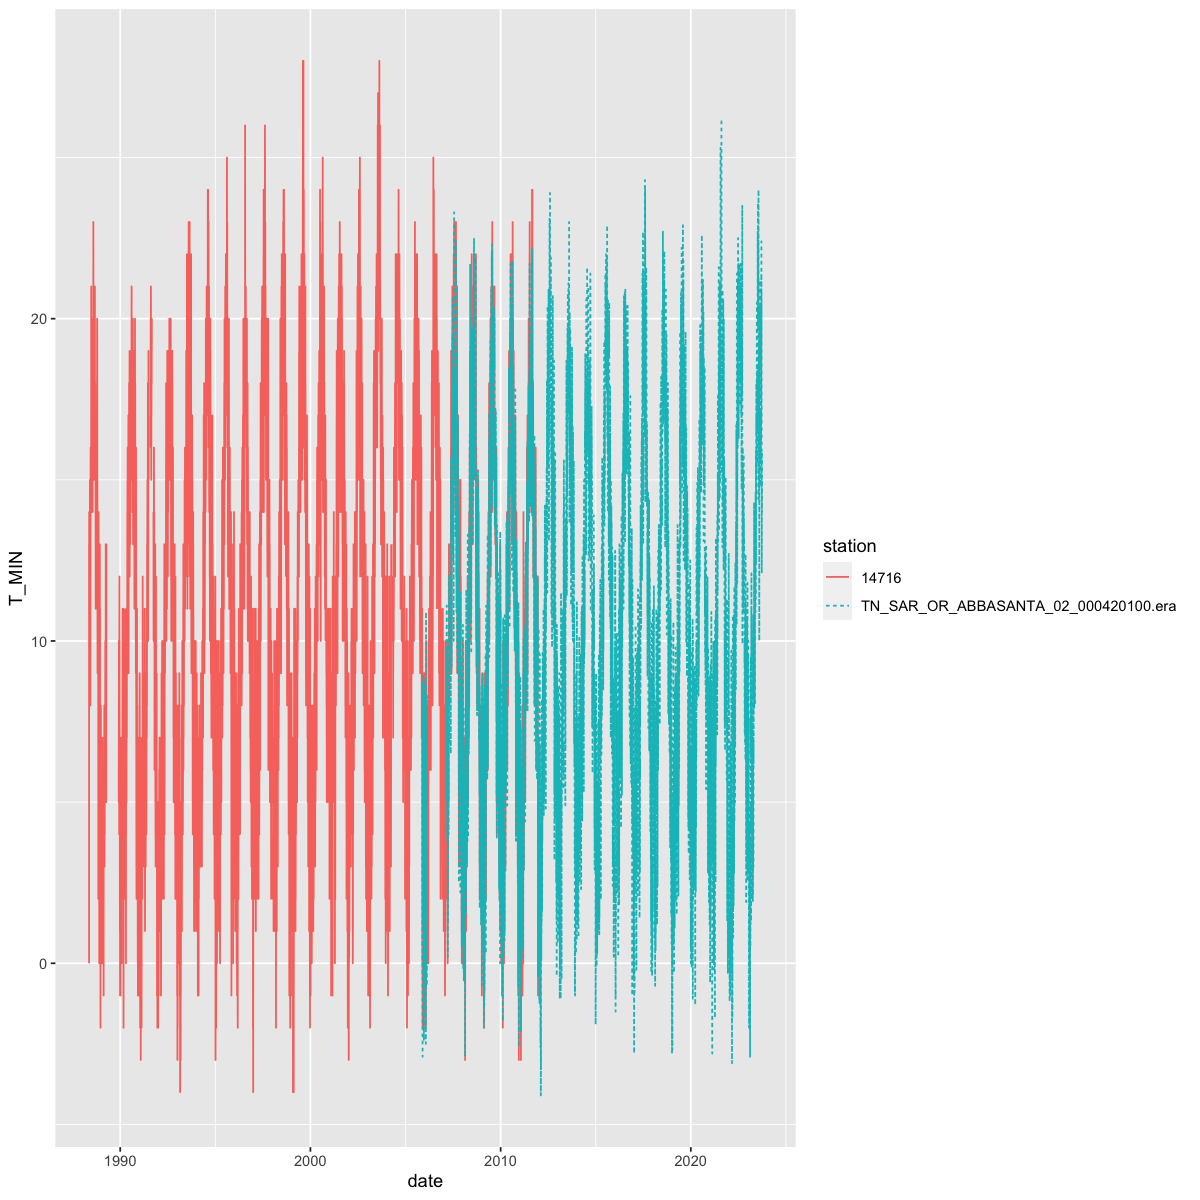

In [10]:
options(repr.plot.width = 10, repr.plot.height = 10)
plot.sciavsdpc(tvar, 14716, "TN_SAR_OR_ABBASANTA_02_000420100.era", "qc_era5")


In [13]:
source("src/load/load.R")
s1 <- read.series.single("SCIA", tvar, 14716)
s2 <- read.series.single("DPC", tvar, "TN_SAR_OR_ABBASANTA_02_000420100.era", "qc_era5")
s <- inner_join(s1, s2, by = "date") |> mutate(delT = T_MIN.x - T_MIN.y)


In [25]:
diffs <- s |>
    filter(2009 <= year(date) & year(date) <= 2012) |>
    drop_na() |>
    index_by(month = ~ month(.)) |>
    summarise(dT = mean(delT, na.rm = TRUE))


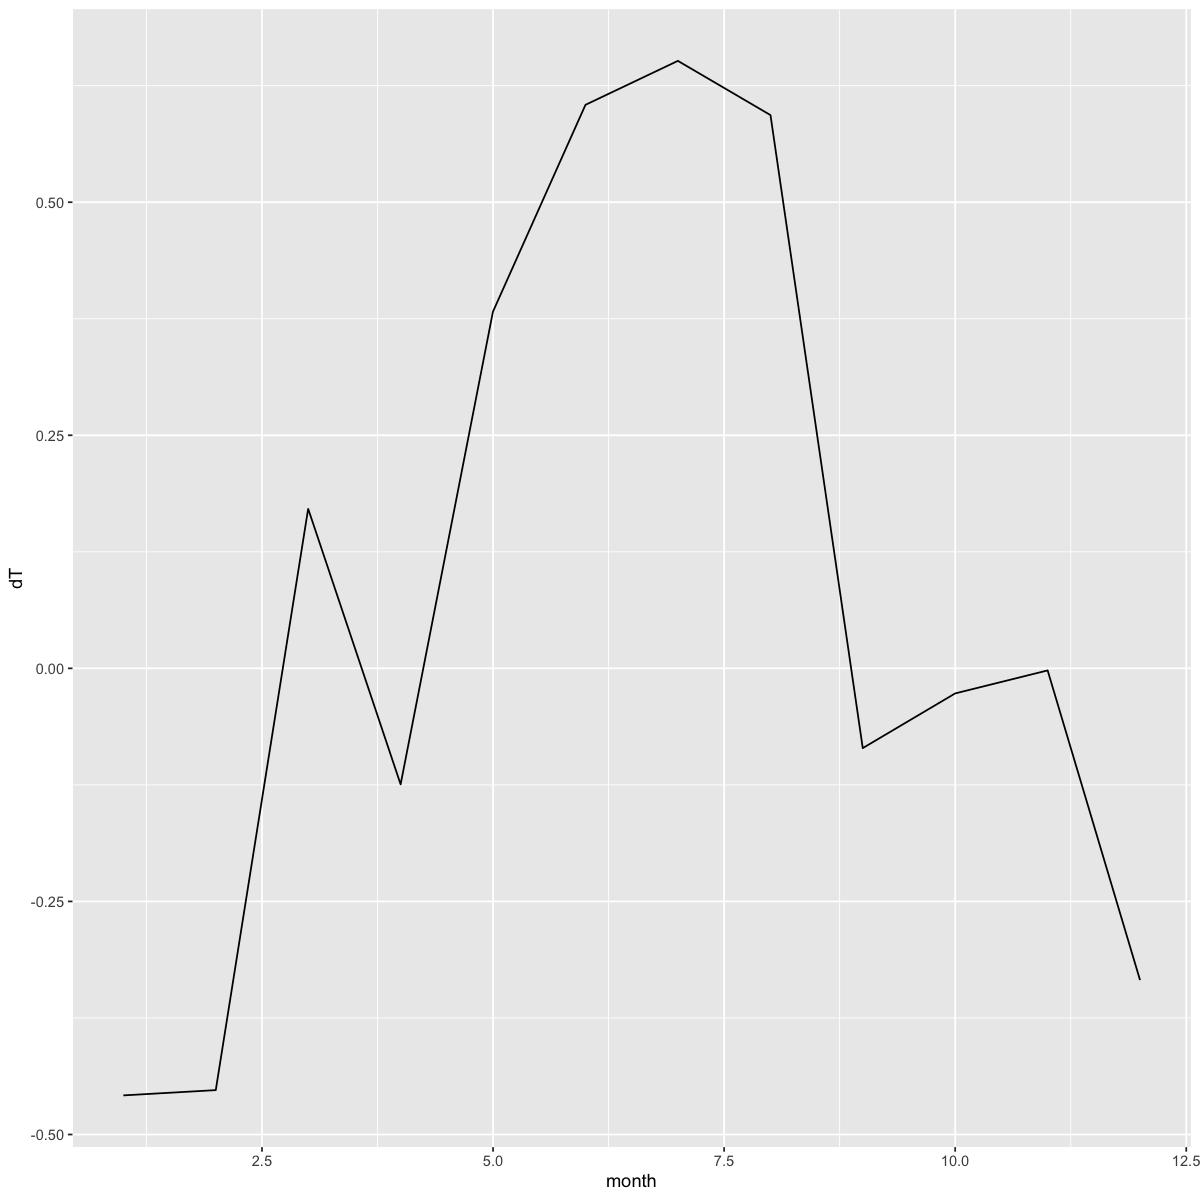

In [26]:
ggplot(diffs) + geom_line(aes(x = month, y = dT))